# Overview of Electricity Generation in the USA based on EIA data

The following is an exercise in using data from the Electricity Information Agency (EIA),
to familiarize myself with both the broad state of the US electrical grid, as well as some elementary data science.
This is based on the bulk ELEC dataset, which contains monthly temporal resolution, and has plant level
and state level summaries.  The dataset includes generation by source, fuel quality, number of customers, cost of electricity and sales.
While the EIA offers an API for current access, but as someone new to this dataset it was simpler to start exploring from the bulk data set, which is only around 1GB. 

I have converted the bulk data file from (url_here) to a local SQL database.
I used Psycopg2 for direct SQL interaction with that PostGRESQL database. 
I can then efficiently select data from that database, based on geographic region and type of generation.  (While the data should nominally fit into memory in one Pandas dataframe, I found that my computer ran out of memory before it could be loaded.) 

The resulting queries from SQL can then be converted into a Pandas dataframe.  Since the data is of the form
"[[date1,number1],[date2,number]...], as one long string, this is converted into a list, then a Numpy array.
The first column is used to generate a Pandas PeriodIndex (which is then further converted to a DateTimeIndex for plotting reasons).  The second column is then indexed.  The resulting series is output as the elements of a list of series for the desired state, and generation type.  
These results can then be plotted using basic Matplotlib.

In [59]:
import pandas as pd
import numpy as np
import sqlalchemy
import psycopg2
import datetime 
import matplotlib.pyplot as plt
from psycopg2 import sql
from mpl_toolkits.basemap import Basemap  #mapping utility
import pickle   #Useful for caching maps

#from sql_lib import create_conn_and_cur

The data is provided as JSON format, with lots of metadata, and connections between series.  The data was split into chunks, and loaded into SQL as text (The time series proper were also stored as a single list for each entry.)

In [2]:
#Set up connections to SQL database, which was generated from the bulk JSON file.
database_name='US_ELEC'
fname='ELEC'
table_name=fname
engine=sqlalchemy.create_engine("postgresql+psycopg2://localhost/"+database_name)

#make connection to database (which is needed by Pandas), 
# and the cursor which actually executes SQL commands.
conn=psycopg2.connect(dbname=database_name,host='localhost')
conn.set_session(autocommit=True)
cur = conn.cursor()


In [19]:
#count the number of series
q=sql.SQL('SELECT count(*) FROM "ELEC"')
cur.execute(q)
cur.fetchall()

[(562601,)]

In [38]:
#grab a single entry to look at data
q=sql.SQL('SELECT * FROM "ELEC" LIMIT 1')
cur.execute(q)
cur.fetchall()

[(None,
  'None',
  "[['201610', 0], ['201609', 0], ['201608', 0], ['201607', 0], ['201606', 0], ['201605', 0], ['201604', 0], ['201603', 0], ['201602', 0], ['201601', 0], ['201512', 1418.256], ['201511', 1054.906], ['201510', 1486.568], ['201509', 2253.374], ['201508', 2768.4], ['201507', 3127.131], ['201506', 2533.656], ['201505', 2061.714], ['201504', 1615.009], ['201503', 1478.928], ['201502', 1471.735], ['201501', 1404.323], ['201412', 1324.31], ['201411', 1119.293], ['201410', 1353.77], ['201409', 1682.966], ['201408', 2552.57], ['201407', 3119.264], ['201406', 2985.718], ['201405', 2789.377], ['201404', 1913.604], ['201403', 1285.439], ['201402', 981.838], ['201401', 1097.851], ['201312', 801.46], ['201311', 896.957], ['201310', 1222.079], ['201309', 1529.527], ['201308', 2273.543], ['201307', 2763.516], ['201306', 2474.029], ['201305', 2342.961], ['201304', 1949.803], ['201303', 1546.639], ['201302', 1301.507], ['201301', 1466.979], ['201212', 2199.957], ['201211', 1702.776], [

The following defines some useful functions for grabbing SQL queries, and loading the desired columns into a Pandas DataFrame.
Most of this is just converting python variables to SQL variables, for simple SQL queries of the form
"SELECT {columns} FROM table WHERE name like '{pattern}' and freq LIKE {freq}".

In [3]:
#make SQL queries, with desired list of columns in "out_columns".
#Assume we are searching through name for entries with desired type of series, for particular states,
#as well as generation type.
def safe_sql_query(table_name, out_columns, match_names, freq):
    """safe_sql_query(table_name, out_column, match_names, freq)
    Extract a set of columns where the name matches certain critera.

    Input:
    table_name - name for table
    out_columns - list of desired columns
    match_names - desired patterns that the name must match.  (All joined via AND)
    freq   - desired frequency     

    Return: 
    sql query to carry out desired command.
    """

    col_query=sql.SQL(' ,').join(map(sql.Identifier,out_columns))
    #make up categories to match the name by.
    namelist=[];
    for namevar in match_names:
        namelist.append(sql.Literal('%'+namevar+'%'))
        #join together these matches with ANDs to match them all
        name_query=sql.SQL(' AND name LIKE ').join(namelist)
    #Total SQL query to select desired columns with features 
    q1 = sql.SQL("SELECT {0} FROM {1} WHERE (name LIKE {2} AND f LIKE {3}) ").format(
        col_query,
        sql.Identifier(table_name),
        name_query,
        sql.Literal(freq))
    return(q1)

def get_column_query(table_name, out_column):
    """get_column_query(table_name, out_column)
    Return SQL query to extract 'out_column' from 'table_name'
    """
    #make up categories to match the name by.
    #Total SQL query to select desired columns with features 
    q1 = sql.SQL("SELECT {0} FROM {1}").format(
        sql.Identifier(out_column),
        sql.Identifier(table_name))
    return(q1)

#Get a dataframe from SQL database for given psycopg2 cursor,
#with desired output columns.     
#Must select data based on series type, state, and type of generation.
def get_dataframe(cur, table_name, out_columns, match_names, freq):
    """get_dataframe(cur, table_name, out_columns, match_names, freq)
    Generate pandas dataframe from calling SQL database. 
    Dataframe will contain 'out_columns', in cases where the names 
    contain all of the entries in 'match_names'

    Input: cur - psycopg2 cursor connected to database
    table_name -SQL table name
    out_columns - columns to extract from SQL
    match_names - list of strings that the 'name' must match
    freq      - desired frequency

    Output:
    df  - pandas Dataframe
    """
    
    q = safe_sql_query(table_name,out_columns,match_names,freq)
    cur.execute(q);
    df0=cur.fetchall();
    df = pd.DataFrame(df0,columns=out_columns);
    return df


In [29]:
#just use categories table, which already found the distinct
#high level labels. 


In [4]:
#Initial readin of SQL dataframes returns 'data' as a string of a list of lists.  
#This function goes row by row, converting that 'data' column
#into a new series, with datetimeindex in 'data2'

# Make a Period Index - really, really easy.
#But plotting is limited with "Periods".  It seems only
#"DateTimeIndices" allow easy combinations.  Use to_timestamp to convert to a DatetimeIndex.
def convert_data(df):
    Nrows=len(df)
    print('Nrows',Nrows)
    data_array=[];
    for i in range(0,Nrows):
        #check there's actually data there.
        #use next line since the read in dataframe has returned a string.
        #print('Converting #',i)
        init_series=np.asarray(eval(df.iloc[i]['data']))
        dat2=init_series[:,1].astype(float);
        f = df.iloc[i]['f']
        periodindex=pd.PeriodIndex(init_series[:,0],freq=f)
        s=pd.Series(dat2,index=periodindex)
        data_array.append(s.to_timestamp())
    return data_array


## United States Seasonal Variation

Let's now look at national level data for the United States as a whole.

In [5]:
#grab the data from SQL.  Also converts each data string into a series (associated with each name/id)
out_col=('name','data','start','end','f')
match_names=[': United States :'];    
df_usa=get_dataframe(cur,'ELEC',out_col,match_names,freq='M');
data0=convert_data(df_usa)
df_usa['data2']=data0

Nrows 915


First, lets look at the types of series available on a national level.  We'll find the type of series by splitting up the names, and counting the numbers of each type.  

In [6]:
#split all series names at ':', and grab first entry of resulting list to get the highest level type of series.
name_split=df_usa['name'].str.split(':')
name0=name_split.apply(lambda x: x[0])
name_df=pd.DataFrame(name0,columns=['name'])
unique_names=name0.unique()

In [7]:
#count up number of each type of series.
counts=np.zeros(len(unique_names))
i=0
for name in unique_names:
    #avoid using regex to allow parentheses
    counts[i]=np.sum(name0.str.contains(name,regex=False))
    i+=1

name_df=pd.DataFrame(data={'name':unique_names,'count':counts})
print(name_df)

    count                                                                name
0     6.0                                        Retail sales of electricity 
1   150.0                     Receipts of fossil fuels by electricity plants 
2   115.0                  Quality of fossil fuels in electricity generation 
3    18.0                      Fossil-fuel stocks for electricity generation 
4     6.0                           Revenue from retail sales of electricity 
5    75.0               Receipts of fossil fuels by electricity plants (Btu) 
6     6.0                                Average retail price of electricity 
7   196.0                                                     Net generation 
8    94.0                                                  Total consumption 
9     5.0                                        Number of customer accounts 
10  150.0            Average cost of fossil fuels for electricity generation 
11   37.0                        Consumption for useful thermal 

The bewildering number of series is due to the number of types of fuel, and differing types of fuels associated with each type of generation, as well as variation by sector and size of generator.  

In [149]:
#Find unique types of generation by further splitting
msk=df_usa['name'].str.contains('Net generation')
df_usa[msk]['name'].str.split(':').apply(lambda x:x[1]).unique()

array([' wind ', ' coal ', ' natural gas ', ' other biomass ',
       ' all utility-scale solar ', ' nuclear ', ' other ',
       ' conventional hydroelectric ', ' wood and wood-derived fuels ',
       ' other gases ', ' hydro-electric pumped storage ',
       ' petroleum liquids ', ' utility-scale photovoltaic ',
       ' utility-scale thermal ', ' all solar ', ' all fuels ',
       ' petroleum coke ', ' distributed photovoltaic ', ' geothermal ',
       ' other renewables (total) '], dtype=object)

Lets now plot the main generators on the national level.  

In [79]:
#Plot out each of the rows of a dataframe, with the label given by the name of the row.
def plot_data_frame(df,title,xlabel,ylabel,labels=None,logy=False):
    if labels is None:
        labels=df['name'].values
    for i in range(0,len(df)):
        if (logy==True):
           plt.semilogy(df.iloc[i]['data2'],label=labels[i])
        else:
           plt.plot(df.iloc[i]['data2'],label=labels[i])           
    plt.legend(loc='upper left',bbox_to_anchor=(1,1))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)        
    plt.title(title)
    plt.show()
    return

In [106]:
#select out series across all sectors for each type of generation
msk1=df_usa['name'].str.contains('Net generation')
msk2=df_usa['name'].str.contains('all sectors')
df_gen=df_usa[msk1&msk2]
#now sort plotting order by which has largest values.
df_gen_max=df_gen['data2'].apply(max)
plt_ind=df_gen_max.sort_values(ascending=False).index
#extract out source part of labels via regex, select first match, and convert to array
gen_labels=df_usa.iloc[plt_ind]['name'].str.extractall('Net generation : ([\s\w\(\)-]+):')[0].values

In [54]:
q=sql.SQL('SELECT units FROM "ELEC" WHERE name LIKE \'Net generation : all fuels : United States%:%all sectors%\'')
cur.execute(q)
cur.fetchall()

[('thousand megawatthours',),
 ('thousand megawatthours',),
 ('thousand megawatthours',)]

In [108]:
plot_data_frame(df_usa.iloc[plt_ind],
xlabel='Date',
ylabel='Net Generation (GWh)',title='Generation Across US by source',
labels=gen_labels)

Evidently coal, natural gas and nuclear power provide the vast majority of the US's electrical supply.
While coal use is declining, that decline is matched by an increase in the use of natural gas. 
Nuclear power is fairly stable, reflecting that there are few new nuclear plants being built.

Of the renewables, wind and hydroelectric are the dominant providers.
Hydroelectric is the largest renewable, but is largely static, reflecting the fact that most available hydro sources have already been exploited.
Solar capacity has shown exponential growth, the supply of wind-based electricity generation has been growing over the last decade. 

Note that these are all monthly totals.  These do not capture the short scale fluctuations that can occur on the minute to hour timescale which can impact the usefulness of renewables, and are the primary difficulty in incorporating them into the grid.

Let's look at another plot focusing on the smaller terms, on both log/linear scales.

In [114]:
plt.figure()
plot_data_frame(df_usa.iloc[plt_ind[5:]],
xlabel='Date',
ylabel='Net Generation (GWh)',title='Generation Across US by source',
labels=gen_labels[5:],logy=False)
plt.figure()
plot_data_frame(df_usa.iloc[plt_ind[5:]],
xlabel='Date',
ylabel='Net Generation (GWh)',title='Generation Across US by source',
labels=gen_labels[5:],logy=True)

In [122]:
d0=df_gen[df_gen['name'].str.contains('solar|photo')]
plot_data_frame(d0,
xlabel='Date',
ylabel='Net Generation (GWh)',title='Solar Generation Across US by source')

#plt.plot(d0['data2'])

The last decade has seen wind and solar capacity growing exponentially, with wind having a large overall contribution, while utility scale solar is growing fastest of all. Otherwise there's multiple other small sources, which have been roughly constant over the period. Petroleum liquids show a similar dropoff to coal usage.  

Pumped storage is an anomaly: it's negative, and relatively constant. 

## Oregon's Generation

Let's look at the main contributors for Oregon's electricity generation, looking 

In [138]:
def plot_generation_by_state(state):
    out_col=('name','data','start','end','f')
    match_names=['Net generation',': '+state+' :',': all sectors :'];    
    state_gen=get_dataframe(cur,'ELEC',out_col,match_names,freq='M');
    data0=convert_data(state_gen)
    state_gen['data2']=data0

    state_gen_max=state_gen['data2'].apply(max)
    plt_ind=state_gen_max.sort_values(ascending=False).index
    #extract out source part of labels via regex, select first match, and convert to array
    gen_labels=state_gen.iloc[plt_ind]['name'].str.extractall('Net generation : ([\s\w\(\)-]+):')[0].values

    plot_data_frame(state_gen.iloc[plt_ind],
    xlabel='Date',
    ylabel='Net Generation (GWh)',title='Generation Across '+state+' by source',
    labels=gen_labels,logy=False)
  



In [121]:
# out_col=('name','data','start','end','f')
# OR_gen=pd.DataFrame()
# for gen_type in ('nuclear','coal','natural gas','solar','wind','hydro'):
#     print('Getting '+gen_type);
#     match_names=['Net generation',': Oregon :',gen_type, ': all sectors :'];
#     df=get_dataframe(cur,'ELEC',out_col,match_names,freq='M');
#     data0=convert_data(df)
#     df['data2']=data0
#     OR_gen=OR_gen.append(df)
# OR_gen.index=np.arange(len(OR_gen))

Nrows 1


Nrows 1
Getting hydro


Nrows 2
Getting wind


Nrows 1
Getting solar


Nrows 1
Getting natural gas


Nrows 0
Getting coal


Getting nuclear


In [146]:
plot_generation_by_state('Iowa')

Nrows 14


So hydroelectric and natural gas are the main generators, followed by wind.  There's small amount of energy provided by coal in the peak months of summer/winter.  The other sources appear to be negligible.  

## Cost of Electricity

The other side of this is looking at the markets: customers, sales and costs of electricity.  Generation might occur in one place, but be sold to another state.  

In [160]:
msk=df_usa['name'].str.contains('retail')
df_usa[msk]['name'].str.split(':').apply(lambda x:x[2]).unique()

array([' United States '], dtype=object)

In [ ]:
df_usa[msk]

## Geographic variability in 2016

Time to break out some Matplotlib.baseplot goodness for plots of the US.
(This is also directly relevant to the data available from the EIA, since the US is broken into 5 major power regions,
which then interact by buying and selling electricity from one another.)
Using annual data, which states use the most electricity of each type?


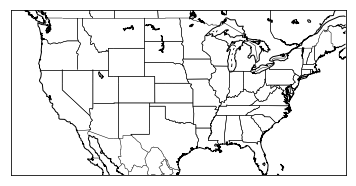

Creating Fine BaseMap and storing with pickle


In [6]:
# try:
# 	#Check if pickled(saved) Basemap instance is available - saves lots of time
# 	m=pickle.load(open('usstates.pickle','rb'))
# 	print('Loading Map from pickle')
# except:
#if not, remake the Basemap (costs lots of time)
plt.figure()  
print('Creating Fine BaseMap and storing with pickle')
m=Basemap(projection='merc',llcrnrlon=-130,llcrnrlat=25,\
        urcrnrlon=-65,urcrnrlat=50,resolution='l', \
        lon_0=-115, lat_0=35)
m.drawstates()
m.drawcountries()
#pickle.dump(m,open('map.pickle','wb'),-1)
#actually draw the map
m.drawcoastlines()
plt.show()


## Near Real-time data.

Now to load in some of the actual operating data (which is in a different table in the same database).
Ok, that is not really working, since I screwed up loading the data into the database.


In [7]:
database_name='US_ELEC'
fname='EBA'
table_name=fname
engine2=sqlalchemy.create_engine("postgresql+psycopg2://localhost/"+database_name)
#make connection to database (which is needed by Pandas), 
# and the cursor which actually executes SQL commands.
conn2=psycopg2.connect(dbname=database_name,host='localhost')
conn2.set_session(autocommit=True)
cur2 = conn2.cursor()

In [35]:
def fetch_eba_series(cur2,region,series_type):
    """fetch_eba_series(cur2,region,series_type)
    Call PostgreSQL server to pull up the series relating to
    a given region and type of series.
    
    cur2: psycopg2 cursor object on relevant table
    region: name of the region/ISO we want the series for
    series_type: the type of data series for a given ISO
    """
    print('Getting '+region+':'+series_type);
    df=get_dataframe(cur2,'EBA',out_col,[region,series_type],freq='H');
    data0=convert_data(df)
    df['data2']=data0
    return df

#Read in some representative data.
out_col=('name','data','start','end','f')
df_eba_tot=pd.DataFrame()

region_list=["Northwest (region)",'Southwest (region)','Southeast (region)',\
            'Midwest (region)','Central (region)','California (region)',\
            'Texas','Tennessee','Florida (region)','Carolinas (region)','New York','New England'];
series_type=['Net generation','Demand','demand forecast','retail'];
for region in region_list:
#     for gen_type in series_list:
    series_type='Demand'
    df = fetch_eba_series(cur2,region,series_type)
    print(df['name'])
    df_eba_tot=df_eba_tot.append(df)


Getting Northwest (region):Demand
1
Converting # 0
0    Demand for Northwest (region), Hourly
Name: name, dtype: object
Getting Southwest (region):Demand
1
Converting # 0
0    Demand for Southwest (region), Hourly
Name: name, dtype: object
Getting Southeast (region):Demand
1
Converting # 0
0    Demand for Southeast (region), Hourly
Name: name, dtype: object
Getting Midwest (region):Demand
1
Converting # 0
0    Demand for Midwest (region), Hourly
Name: name, dtype: object
Getting Central (region):Demand
1
Converting # 0
0    Demand for Central (region), Hourly
Name: name, dtype: object
Getting California (region):Demand
1
Converting # 0
0    Demand for California (region), Hourly
Name: name, dtype: object
Getting Texas:Demand
1
Converting # 0
0    Demand for Electric Reliability Council of Texas, Inc. (ERCO), Hourly
Name: name, dtype: object
Getting Tennessee:Demand
1
Converting # 0
0    Demand for Tennessee Valley Authority (TVA), Hourly
Name: name, dtype: object
Getting Florida (regio

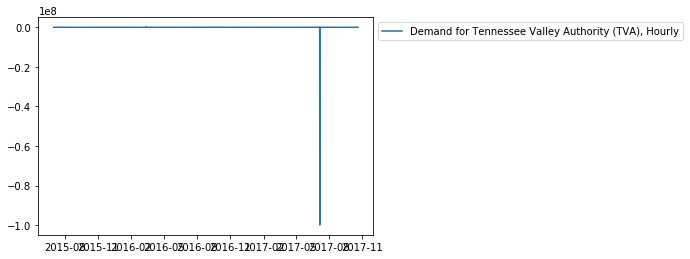

In [46]:
plot_data_frame(df_eba_tot[7:8])
#plot_data_frame(df_eba_tot)

In [52]:
d0=df_eba_tot[7:8]['data2']
np.argmax(d0)

ValueError: setting an array element with a sequence.

In [34]:
i0=0
d0=df_eba_tot.iloc[i0*3]['data2'];  #Generation
d1=df_eba_tot.iloc[i0*3+1]['data2'];  #Actual Demand
d2=df_eba_tot.iloc[i0*3+2]['data2'];  #Day ahead demand forecast

KeyError: 'data2'

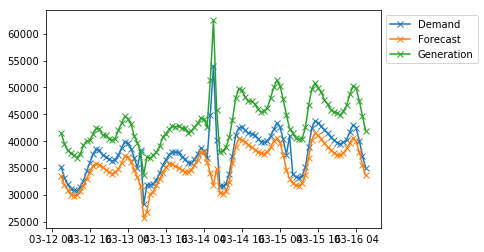

In [33]:
#check for weird points.  This plot is fore the region of maximum discrepency between the forecast and actual demand.
t0=np.argmax(abs(d2-d1))
delta=pd.Timedelta(2,'D');
t1 = t0-delta;
t2= t0+delta;
trange=pd.DatetimeIndex(start=t1,end=t2,freq='H')
plt.plot(trange,d1[trange],'-x',label='Demand')
plt.plot(trange,d2[trange],'-x',label='Forecast')
plt.plot(trange,d0[trange],'-x',label='Generation')
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()


In [ ]:
So that wasn't an error, but a real spike in demand.  Obviously the generation made up the difference.

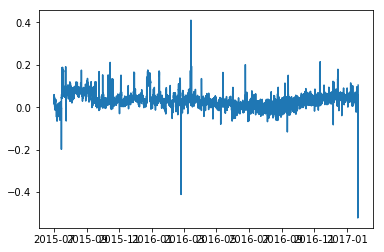

In [34]:

plt.plot(1-d2/d1)
plt.show()

Finally (months after I first wanted to do this), we can start looking at some data.  
I would like to review the sources of electricity to get a sense of seasonal variations (in terms of availability and use).  For example, I'd expect solar generation to be largest in summer, lowest in winter.  
I would assume this varies geographically.  I'll assume the seasonality can be averaged over by using the annual data. 

Residential Use will be largest in winter, barring the occasional fluctuation in summer.  

The purpose of this survey is to identify the scale of renewables in the market.  
How large a share do renewables (solar, hydro, wind) take up?  How does this vary regionally?  Over time? 
Who are the primary users of electricity?  
I'll assume the base load is provided by coal, gas and nuclear plants.  


Ultimately however, I intend to try my hand at some machine learning projects relevant to electricity.  
The first project involves demand forecasting.  The other place where data science (and nifty math) may have a role in this, is on the market.  While I am comfortable with stochastic calculus etc, I would need to learn about options pricing
and the relevant techniques for this sector of the energy market.

This is meant to be a brief background piece for that.  Since we are forecasting a time series,
I aim to use TensorFlow with some form of neural network (perhaps recurrent) to try forecasting.
Ideally, I would cross-reference the electricity data sets against the published weather forecasts for a given day.  
The model should be able to predict demand given the location, time of year, and weather forecast.  (This is probably the 
simplest thing available)

From a smart-grid perspective, how can randomly fluctuating sources, such as solar and wind, be included 
in supplying power to the grid?  